In [1]:
import re
import numpy as np
import os
from tools import *
import pickle
%matplotlib inline

## PCL + Features

In [8]:
# set up
log_file_name = "perc_log/roi_cloud_0206.log"

# parse log
roi_pcl_frames, feature_frames, ... = parse_log(log_file_name,20)

0% [█████████████████████] 100% | ETA: 23:59:59
Total time elapsed: 00:00:23


In [ ]:
# export pcl demo
print "Exporting PCL"
pcl_demo(roi_pcl_frames)

# export mean height demo
print "Exporting Mean H"
feature_demo(feature_frames[1], "mean_height")

# export mean intensity demo
print "Exporting Mean I"
feature_demo(feature_frames[5], "mean_intensity")

# export count demo
print "Exporting Count"
feature_demo(feature_frames[2], "count")

## Fine PCL Plot

In [171]:
# set up
log_file_name = "perc_log/roi_cloud_0204.log"

# parse log
roi_pcl_frames,_ = parse_log(log_file_name,100)

0% [███████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


In [ ]:
pcl_demo(roi_pcl_frames, name='fine_pcl',fps = 5,n_frames=100)

## CNN Seg Model

In [9]:
def transform(feature, frm_idx):
    return np.array([[np.reshape(np.array(feature[frm_idx]),(512,512)) for feature in feature_frames]])

In [139]:
features_name = ["Max height", "Mean height", "Count", "Direction", "Max intensity", "Mean intensity", "Distance", "Nonempty"]
# for feature in input_feature:
#     print feature.shape, feature.max(), feature.min()
def constrainted_perturb(features, adv_sign, delta):
    feature_range = [[-5,5],[-5,5],[0,5],[],[0,1],[0,1],[],[]]
    constraint_feature = [4,5]
    ae_features = np.copy(features)
    for idx in constraint_feature:
        ae_features[idx] = np.minimum(np.ones([512,512])*feature_range[idx][1],
        np.maximum(np.ones([512,512])*feature_range[idx][0],
                                      features[idx] + adv_sign[0][idx]*delta*(feature_range[idx][1] - feature_range[idx][0])))

    ae_features[0][7] = (ae_features[0][2] > 0).astype(int)
    return ae_features

In [143]:
# load data
roi_pcl_frames,feature_frames,objs_frames = pickle.load(open("perc_log/minbox_0.p",'rb'))

In [148]:
features = np.array([np.reshape(feature[6],(512,512)) for feature in feature_frames])

In [167]:
# caffe model
import caffe

# model to attack
model_definition = 'deploy.prototxt'
model_weights = 'deploy.caffemodel'

# init net
net = caffe.Net(model_definition, model_weights, caffe.TEST)

# transform input
# input_feature = transform(feature_frames, 0)
input_feature = features
print input_feature.shape

# get output
net.blobs['data'].data[0] = input_feature
net.forward()
outputs = ['category_score','class_score','confidence_score',
#            'heading_pt',
           'height_pt','instance_pt']
for output in outputs:
    print output, net.blobs[output].data.shape, net.blobs[output].data.max(), net.blobs[output].data.min()
output_data = [net.blobs[output].data[0] for output in outputs]

(8, 512, 512)
category_score (1, 1, 512, 512) 0.9999994 0.0
class_score (1, 5, 512, 512) 0.99987847 3.4748633e-09
confidence_score (1, 1, 512, 512) 0.9999465 6.073313e-10
height_pt (1, 1, 512, 512) 3.277693 -2.6754622
instance_pt (1, 2, 512, 512) 0.6046132 -0.58300865


0.012919439


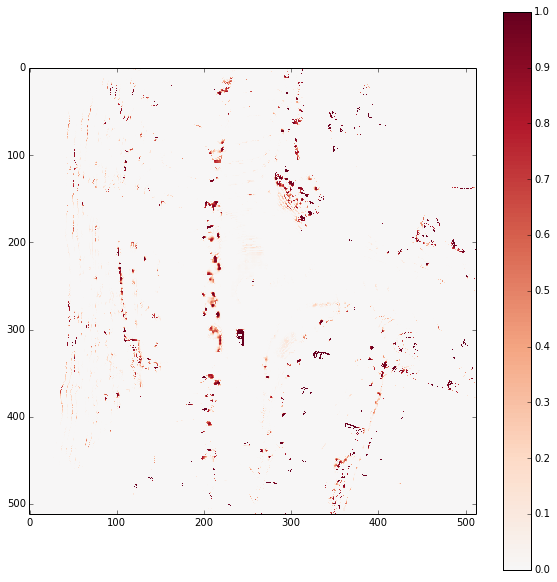

In [168]:
print output_data[0][0].mean()
draw_feature(output_data[0][0])

## Cluster

In [166]:
class Node:
    def __init__(self):
        self.center_node = (-1,-1)
        self.parent = (-1,-1)
        self.traversed = 0
        self.is_center = False
        self.is_object = False
        self.point_num = 0
        self.obs_id = -1
        self.node_rank = 0

def Traverse(grid, x):
    pts = []
    while grid[x].traversed == 0:
        pts.append(x)
        grid[x].traversed = 2
        x = grid[x].center_node
    if grid[x].traversed == 2:
        for p in pts:
            grid[p].is_center = True
    for p in pts:
        grid[p].traversed = 1
        grid[p].parent = grid[x].parent

# DJS
def DJSMakeSet(grid,x):
    grid[x].parent = x
    grid[x].node_rank = 0

def DJSFindRecursive(grid,x):
    if grid[x].parent!=x:
        grid[x].parent = DJSFindRecursive(grid,grid[x].parent)
    return grid[x].parent

def DJSFind(grid,x):
    y = grid[x].parent
    if y == x or grid[y].parent == y:
        return y
    root = DJSFindRecursive(grid, grid[y].parent)
    grid[x].parent = root
    grid[y].parent = root
    return root

def DJSUnion(grid, x, y):
    x = DJSFind(grid, x)
    y = DJSFind(grid, y)
    if x==y:
        return
    if grid[x].node_rank < grid[y].node_rank:
        grid[x].parent = y
    elif grid[x].node_rank > grid[y].node_rank:
        grid[y].parent = x
    else:
        grid[y].parent = x
        grid[x].node_rank += 1

def IsValidCell(x,y):
    if x >=0 and y>=0 and x <grid_size and y < grid_size:
        return True
    else:
        return False

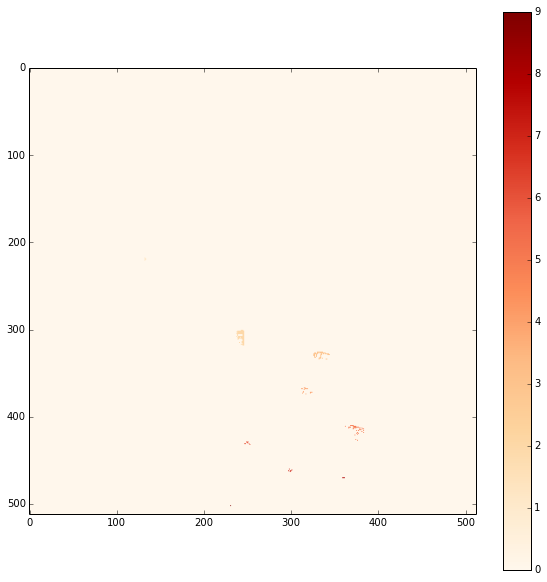

In [169]:
# conf
object_thresh = 0.5
confidence_thres = 0.1
grid_size = 512
grid = np.empty( (grid_size,grid_size), dtype=object)
grid.flat = [Node() for _ in grid.flat]
scale = 0.5 * grid_size/60.0

category_score = output_data[0][0]
class_score = output_data[1] #(1, 5, 512, 512)
confidence_score = output_data[2] # (1, 1, 512, 512)
# heading_pt = output_data[3] # (1, 2, 512, 512)
height_pt = output_data[3] #(1, 1, 512, 512)
instance_pt = output_data[4] #(1, 2, 512, 512)

# construct graph
for i in range(grid_size):
    for j in range(grid_size):
        x = (i,j)
        DJSMakeSet(grid,x)
        grid[x].is_object = (category_score[x] >= object_thresh)
        grid[x].center_node = (min(max(0,int(round(instance_pt[0][x]*scale+x[0]))),grid_size-1),
                               min(max(0,int(round(instance_pt[1][x]*scale+x[1]))),grid_size-1))
# traverse node
for i in range(grid_size):
    for j in range(grid_size):
        x = (i,j)
        if grid[x].is_object and grid[x].traversed == 0:
            Traverse(grid,x)
for i in range(grid_size):
    for j in range(grid_size):
        x = (i,j)
        if not grid[x].is_center:
            continue
        for i2 in [i-1,i,i+1]:
            for j2 in [j-1,j,j+1]:
                if (i2 == i or j2 ==j) and IsValidCell(i2,j2):
                    x2 = (i2,j2)
                    if grid[x2].is_center:
                        DJSUnion(grid,x,x2)

obs_list = []
for i in range(grid_size):
    for j in range(grid_size):
        x = (i,j)
        if not grid[x].is_object:
            continue
        root = DJSFind(grid,x)
        if grid[root].obs_id < 0:
            grid[root].obs_id = len(obs_list)
            obs_list.append([])
        obs_list[grid[root].obs_id].append((i,j))
        
# filter
out_obs = []
for obs in obs_list:
    confidence = 0
    height = 0
    
    if len(obs) < 3:
        continue
    out_obs.append([])
    for pt in obs:
        confidence += confidence_score[0][pt]
        height += height_pt[0][pt]
        if confidence > confidence_thres * len(obs):
            out_obs[-1].append(pt)
    if out_obs[-1] == []:
        out_obs.pop()

# visualizatiomn
draw_clusters(out_obs)

In [71]:
def draw_cluster(obs):
    grid = np.zeros((grid_size,grid_size))
    for pt in obs:
        grid[pt] = 1
    %matplotlib inline
    import matplotlib.pylab as plt
    from tools import MidpointNormalize
    plt.figure(figsize=(10,10))
    plt.imshow(grid, cmap='RdBu_r')
    plt.colorbar()
    plt.show()
    
def draw_clusters(obs_list):
    grid = np.zeros((grid_size,grid_size))
    label = 1
    for obs in obs_list:
        for pt in obs:
            grid[pt] = label
        label +=1
    %matplotlib inline
    import matplotlib.pylab as plt
    from tools import MidpointNormalize
    plt.figure(figsize=(10,10))
    plt.imshow(grid,cmap='OrRd')
    plt.colorbar()
    plt.show()

## MinBox Builder

In [4]:
# set up
log_file_name = "/data/yulongc/perc_log/part_0.log"

# parse log
roi_pcl_frames, feature_frames, objs_frames = parse_log(log_file_name,10)

0% [██████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


In [6]:
pickle.dump([roi_pcl_frames,feature_frames,objs_frames],open("perc_log/minbox_0.p",'wb'))

In [10]:
pcl_demo(roi_pcl_frames, name='pcl_0219',fps = 1,n_frames=10)

Preparing animation frames...


0% [██████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:24


...Animation frames ready.

[MoviePy] Building file pcl_0219_data.gif with imageio


 91%|█████████ | 10/11 [00:03<00:00,  2.86it/s]


In [177]:
def draw_anotated_pcl(pcl,objs):
    %matplotlib inline
    import matplotlib.pylab as plt
    import matplotlib
    from mpl_toolkits.mplot3d import Axes3D
    import math
    # import seaborn as sns; sns.set()
    
    roi_pcl = np.array(pcl)
    px = [p[0] for p in roi_pcl]
    py = [p[1] for p in roi_pcl]
    pz = [p[2] for p in roi_pcl]
    pi = [p[4] for p in roi_pcl]
    n = len(px)
    point_size = 0.05
    axes_limits = [
        [-80,80], # X axis
        [-15,15], # Y axis
        [-3,3] # Z axis
    ]
    
    # Plot x-y, y-z, x-z
    f,ax = plt.subplots(3,1,figsize=(20,5*3))
    # ax = fig.add_subplot(111, projection='3d')
    ax[0].scatter(px,py,c = pi,cmap='gray',s=point_size)
    ax[0].set_xlabel('X axis')
    ax[0].set_ylabel('Y axis')
    ax[0].set_xlim(axes_limits[0])
    ax[0].set_ylim(axes_limits[1])
    for obj in objs:
        center = (obj[0],obj[1])
        length = obj[3]
        width = obj[4]
        if obj[6] == 0:
            angle = 90
        else:
            angle = 180/3.14 * math.atan(obj[5]/obj[6])
        rect = matplotlib.patches.Rectangle(center, width, length, angle=angle, fill=False,linewidth=2,edgecolor='g')
        ax[0].add_patch(rect)
    ax[1].scatter(py,pz,c = pi,cmap='gray',s=point_size)
    ax[1].set_xlabel('Y axis')
    ax[1].set_ylabel('Z axis')
    ax[1].set_xlim(axes_limits[1])
    ax[1].set_ylim(axes_limits[2])
    ax[2].scatter(px,pz,c = pi,cmap='gray',s=point_size)
    ax[2].set_xlabel('X axis')
    ax[2].set_ylabel('Z axis')
    ax[2].set_xlim(axes_limits[0])
    ax[2].set_ylim(axes_limits[2])
    plt.show()


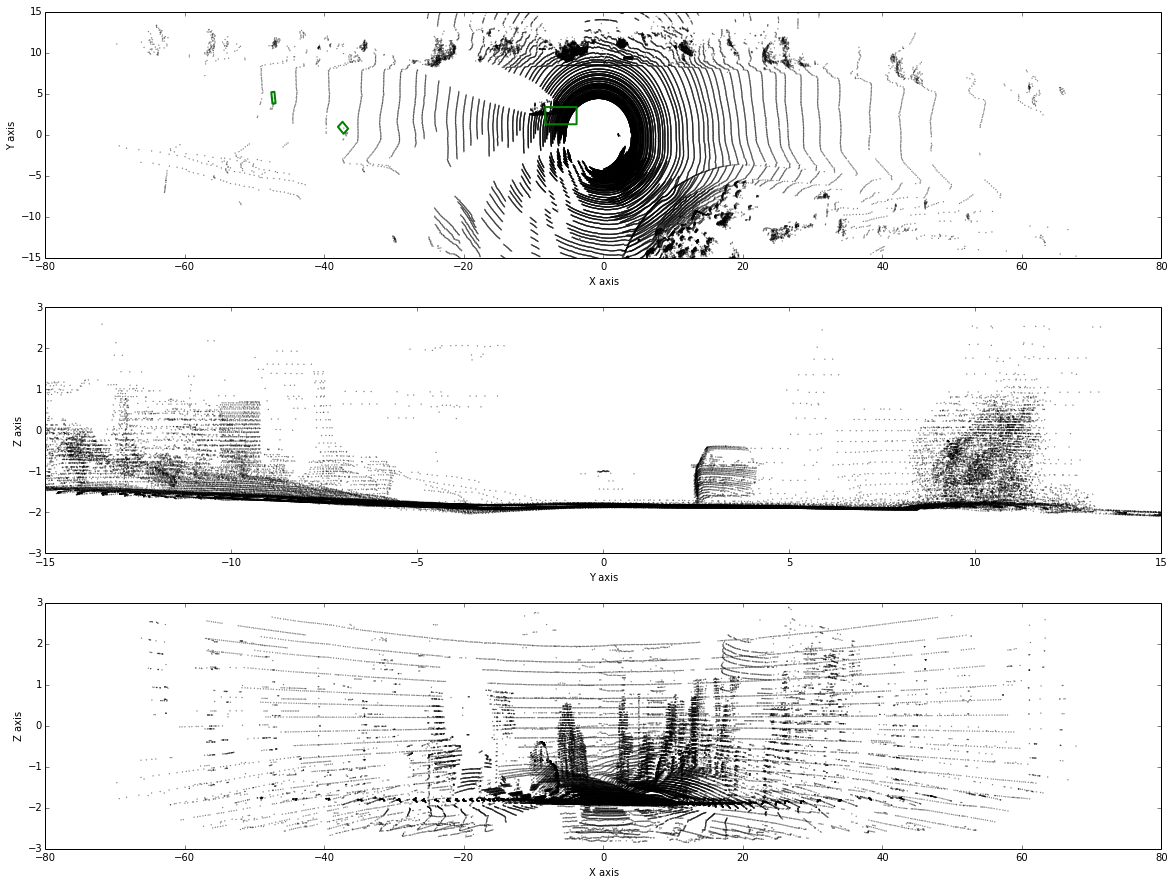

In [15]:
draw_anotated_pcl(roi_pcl_frames[8], objs_frames[8])

In [1]:
# dump pcl files
with open('/data/yulongc/apollo/data/percpt/pcl.out','w') as f:
    for p in roi_pcl_frames[6]:
        f.write('%.15f %.15f %.15f %.15f %.15f\n'%(p[0],p[1],p[2],p[3],p[4]))

NameError: name 'roi_pcl_frames' is not defined

In [174]:
features = np.loadtxt('/data/yulongc/apollo/data/percpt/features.out')
features = np.reshape(features,(8,512,512))

In [154]:
feature_log = np.array([frames[6] for frames in feature_frames])

In [155]:
print [feature.max() for feature in feature_log]
print [feature.max() for feature in features]

[2.747450113296509, 2.747450113296509, 4.219507694244385, 0.499688565731049, 1.0, 2.747450113296509, 0.911451458930969, 1.0]
[2.74745, 2.74745, 4.21951, 0.499689, 1.0, 1.0, 0.911451, 1.0]


In [170]:
# dump ml outputs
def dump_cnn_out(output_data):
    with open('/data/yulongc/apollo/data/percpt/cnn.out','w') as f:
        # category
        for p in output_data[0][0].flatten():
            f.write('%.15f '%(p))
        # class
        f.write('\n')
        for p_class in output_data[1]:
            for p in p_class.flatten():
                f.write('%.15f '%(p))
            f.write('\n')
        # confidence
        for p in output_data[2][0].flatten():
            f.write('%.15f '%(p))
        f.write('\n')
    #     # heading
    #     for heading in output_data[3]:
    #         for p in heading:
    #             f.write('%.15f '%(p))
        # height
        for p in output_data[3][0].flatten():
            f.write('%.15f '%(p))
        f.write('\n')
        # instance
        for instance in output_data[4]:
            for p in instance.flatten():
                f.write('%.15f '%(p))
            f.write('\n')

In [1]:
builder = np.loadtxt('/data/yulongc/apollo/data/percpt/builders/builder_0.out')

NameError: name 'np' is not defined

In [173]:
builder

(9, 8)

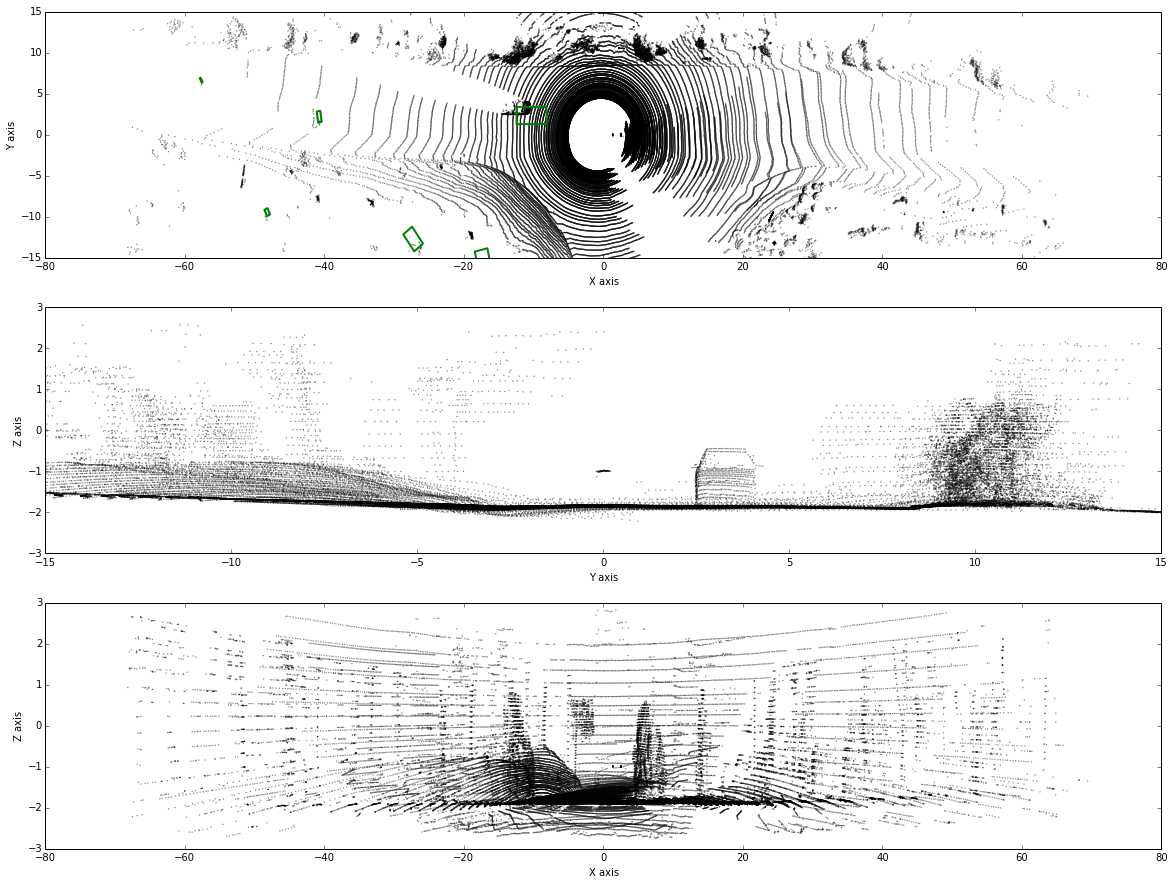

In [178]:
draw_anotated_pcl(roi_pcl_frames[6],builder)

In [6]:
# set up
log_file_name = "/data/yulongc/perc_log/20180319/part_0.log"

# parse log
roi_pcl_frames, _, _ = parse_log(log_file_name,500)

0% [███████████████████████████████] 100% | ETA: 23:59:59
Total time elapsed: 00:00:23


In [7]:
pcl_demo(roi_pcl_frames, name='validation_pcl',fps = 5,n_frames=500)

Preparing animation frames...


0% [███████████████████████████████] 100% | ETA: 23:59:38
Total time elapsed: 00:07:05


...Animation frames ready.

[MoviePy] Building file validation_pcl_data.gif with imageio


100%|██████████| 501/501 [04:48<00:00,  1.30it/s]


In [9]:
path = "/data/yulongc/apollo/data/percpt/pcls/"
for i in range(500):
    with open(path+"pcl_"+str(i)+".out",'w') as f:
        for p in roi_pcl_frames[i]:
            f.write('%.15f %.15f %.15f %.15f %.15f\n'%(p[0],p[1],p[2],p[3],p[4]))